#### Подключаем необходимые библиотеки и  скрипты

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Путь к файлам

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### Загрузка данных

#### Описание датасета

1. Id - идентификационный номер квартиры
2. DistrictId - идентификационный номер районa
3. Rooms - количество комнат
4. Square - площадь
5. LifeSquare - жилая площадь
6. KitchenSquare - площадь кухни
7. Floor - этаж
8. HouseFloor - количество этажей в доме
9. HouseYear - год постройки дома
10. Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
11. Social_1, Social_2, Social_3 - социальные показатели местности
12. Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
13. Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
14. Price - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


#### Приведение типов

In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA

#### Целевая переменная

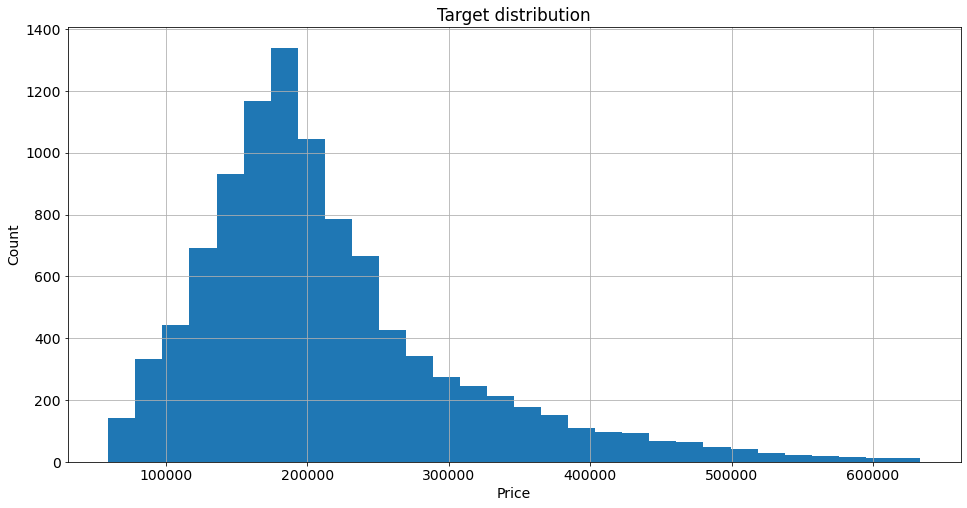

In [8]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [9]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [10]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

## 2. Обработка выбросов и пропусков

#### Rooms

In [11]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [12]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 7), 'Rooms_outlier'] = 1

In [13]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 7, 'Rooms'] = train_df['Rooms'].median()

#### Обработаем пропуски и выбросы связанные с площадью

In [14]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_outlier       0
dtype: int64

#### Для обработки выбросов введем новые расчетные признаки как отношение общей площади к жилой и средняя площадь одной комнаты, для адекватных значений этих переменных уберем пропуски по признаку LifeSquare

In [15]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [16]:
train_df['square_lifesquare'] = train_df['Square'] / train_df['LifeSquare']

#### При обработке выбросов признаков связанных с площадью будем исходить из следующих принципов:
1. Общая площадь всегда больше площади кухни и больше площади жилой
2. Площадь кухни меньше размера площади жилой

In [17]:
train_df[train_df['KitchenSquare'] >= train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,...,915,0,NaN,0,0,B,99079.960518,0,0,2.042023
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,...,5731,0,NaN,1,0,B,160488.033165,0,0,1.930266
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,5285,0,645.0,6,6,B,105539.556275,0,0,1.674240
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,629,1,NaN,0,0,A,108337.484207,0,0,1.014054


In [18]:
train_df[train_df['LifeSquare'] >= train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,...,1437,3,NaN,0,2,B,254005.381863,0,0,0.988989
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,...,264,0,NaN,0,1,B,300180.365669,0,0,0.993963
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,...,5212,6,NaN,3,2,B,247440.530601,0,0,0.970795
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,...,1437,3,NaN,0,2,B,226808.747168,0,0,0.963899
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,...,7687,11,176.0,5,5,B,199248.114376,0,0,0.874662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,9515,5,NaN,1,10,B,524365.550705,0,0,0.978645
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,...,3889,6,705.0,3,6,B,87556.385617,0,0,0.940625
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,...,1564,0,540.0,0,0,B,134888.083598,0,0,0.953766
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,...,264,0,NaN,0,1,B,203908.192698,0,0,0.970390


In [19]:
condition = (train_df['LifeSquare'] >= train_df['Square'])
train_df.loc[condition, 'Square'] = train_df.loc[condition,'LifeSquare']
train_df.loc[condition, 'Square'] = train_df.loc[condition,'Square'] \
                                                      * train_df['square_lifesquare'].median()

In [20]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [21]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [22]:
train_df['square_room'] = train_df['Square'] / train_df['Rooms']

In [23]:
train_df.sort_values(by='LifeSquare').tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare,square_room
5283,11055,151,1.0,268.031240,174.837082,6.0,10,12.0,1958,0.236108,...,27,NaN,3,10,B,232766.187698,0,0,0.998927,268.031240
1776,16568,27,4.0,309.101656,201.627361,6.0,1,2.0,2013,0.041116,...,4,NaN,1,4,B,528560.506016,0,0,0.993588,77.275414
7644,7917,27,1.0,212.932361,211.231125,3.0,2,3.0,2008,0.211401,...,0,NaN,0,1,B,302211.260887,1,0,1.008054,212.932361
1906,5548,86,5.0,275.645284,233.949309,6.0,12,37.0,2011,0.161976,...,5,4508.0,3,7,B,455264.882666,0,0,1.178227,55.129057
357,14990,23,2.0,404.018951,263.542020,5.0,6,5.0,1972,0.075779,...,3,NaN,0,2,B,141780.231857,0,0,0.183841,202.009476
7010,2307,102,1.0,629.524813,410.639749,10.0,4,4.0,2016,0.238617,...,6,705.0,3,6,B,90470.430830,0,0,0.997042,629.524813
5183,15886,85,3.0,707.439540,461.463614,10.0,12,16.0,1998,0.037178,...,1,2300.0,1,7,B,394253.299978,0,0,0.169156,235.813180
726,28,9,2.0,604.705972,600.705972,3.0,17,18.0,1977,0.161532,...,1,30.0,2,4,B,187717.242538,0,1,1.006659,302.352986
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,141,1046.0,3,23,B,133529.681562,0,0,1.004547,320.532596
8000,16550,27,3.0,11468.004170,7480.592129,3.0,9,17.0,2016,0.017647,...,0,NaN,0,0,B,217357.492366,0,0,0.010921,3822.668057


#### Для обработки крайних значений по признаку общей площади отсечем лишь самые неадекватные значения, т.к. квартиры-студии могут иметь очень большую площадь одной комнаты, также в СМИ проходили новости о квартирах площадью менее 10 кв. метров, такие мы тоже оставим

In [24]:
train_df['square_room'].quantile(.999)

167.47948220211995

In [25]:
condition = (train_df['square_room'] >= train_df['square_room'].quantile(.999))
train_df.loc[condition, 'square_room'] = train_df['square_room'].quantile(.999)
train_df.loc[condition, 'Square'] = train_df.loc[condition, 'square_room'] * train_df.loc[condition, 'Rooms']
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition,'Square'] \
                                                      / train_df['square_lifesquare'].median()

In [26]:
train_df['square_room'].quantile(.001)

8.400428511192294

In [27]:
condition = (train_df['square_room'] <= train_df['square_room'].quantile(.001))
train_df.loc[condition, 'square_room'] = train_df['square_room'].quantile(.001)
train_df.loc[condition, 'Square'] = train_df.loc[condition, 'square_room'] * train_df.loc[condition, 'Rooms']
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition,'Square'] \
                                                      / train_df['square_lifesquare'].median()


In [28]:
train_df.sort_values(by='LifeSquare').head(100)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare,square_room
682,16593,52,2.0,64.859242,-0.140758,6.0,15,17.0,1977,0.371149,...,1,750.0,2,5,B,185993.474671,0,1,-460.783996,32.429621
3113,13491,0,1.0,38.178277,0.370619,3.0,19,17.0,2016,0.006076,...,0,645.0,6,6,B,105134.286994,0,0,103.012080,38.178277
1829,4378,27,3.0,106.958871,0.641822,3.0,17,0.0,2018,0.072158,...,1,NaN,0,0,A,337299.867936,0,0,166.648780,35.652957
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,...,0,540.0,0,0,B,174741.998061,0,0,79.935368,31.795870
6882,15402,27,2.0,58.521098,1.049867,3.0,4,17.0,2014,0.072158,...,1,NaN,0,0,A,142393.084641,0,0,55.741425,29.260549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4120,1843,74,1.0,49.635712,3.411048,3.0,4,1.0,1977,0.309479,...,4,990.0,0,6,B,146838.036852,0,0,14.551456,49.635712
6363,14658,6,2.0,62.000239,3.428437,3.0,12,17.0,2014,0.243205,...,0,540.0,0,0,B,185230.373774,0,0,18.084112,31.000120
2557,7838,48,3.0,86.059789,3.434851,3.0,27,1.0,2015,0.041125,...,5,NaN,1,10,B,467773.389759,0,0,25.054883,28.686596
3523,740,9,2.0,66.542124,3.435682,3.0,2,1.0,1977,0.161532,...,1,30.0,2,4,B,181423.633875,0,0,19.367953,33.271062


In [29]:
condition = (train_df['square_lifesquare'] <= 1) | (train_df['square_lifesquare'] > 2)
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition,'Square'] \
                                                      / train_df['square_lifesquare'].median()

#### HouseFloor, Floor

In [30]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [31]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [32]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [33]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [34]:
train_floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [35]:
train_df.loc[train_floor_outliers, 'Floor'] = train_df.loc[train_floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [37]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [38]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 7), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 7, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        #if 'Ecology_2' in X.columns:
            #X.drop('Ecology_2', axis=1, inplace=True)
        #if 'Ecology_3' in X.columns:
           # X.drop('Ecology_3', axis=1, inplace=True) 
        #if 'Shops_2' in X.columns:
           # X.drop('Shops_2', axis=1, inplace=True)
            
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        X['square_lifesquare'] = X['Square'] / X['LifeSquare']
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = (X['LifeSquare'] >= X['Square'])
        X.loc[condition, 'Square'] = X.loc[condition,'LifeSquare']
        X.loc[condition, 'Square'] = X.loc[condition,'Square'] \
                                                      * X['square_lifesquare'].median()
        
        # Square & LifeSquare hi-low
        X['square_room'] = X['Square'] / X['Rooms']
        condition = (X['square_room'] >= X['square_room'].quantile(.999))
        X.loc[condition, 'square_room'] = X['square_room'].quantile(.999)
        X.loc[condition, 'Square'] = X.loc[condition, 'square_room'] * X.loc[condition, 'Rooms']
        X.loc[condition, 'LifeSquare'] = X.loc[condition,'Square'] \
                                                      / X['square_lifesquare'].median()
        
        condition = (X['square_room'] <= X['square_room'].quantile(.002))
        X.loc[condition, 'square_room'] = X['square_room'].quantile(.002)
        X.loc[condition, 'Square'] = X.loc[condition, 'square_room'] * X.loc[condition, 'Rooms']
        X.loc[condition, 'LifeSquare'] = X.loc[condition,'Square'] \
                                                      / X['square_lifesquare'].median()
        
        X.fillna(self.medians, inplace=True)
        
        return X

## 3. Построение новых признаков

#### Dummies

In [39]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [40]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [41]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare,square_room,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,1,1.127417,38.342437,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,1.719200,39.832524,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,1.643360,26.114072,0,652
3,2352,1,1.0,40.409907,36.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,1,1.109860,40.409907,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,1.667035,32.142534,0,89


In [42]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [43]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedM2PriceByDistrict

In [44]:
train_df['m2_price'] = train_df['Price'] / train_df['Square']
med_m2_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'m2_price':'median'})\
                            .rename(columns={'m2_price':'MedM2PriceByDistrict'})

med_m2_price_by_district.head()

,DistrictId,Rooms,MedM2PriceByDistrict
0,0,1.0,4014.374409
1,0,2.0,3697.857111
2,0,3.0,4405.321283
3,1,1.0,3364.153523
4,1,2.0,3139.873820


In [45]:
train_df = train_df.merge(med_m2_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,LifeSquare_nan,square_lifesquare,square_room,HouseFloor_outlier,DistrictSize,IsDistrictLarge,m2_price,MedM2PriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,1.127417,38.342437,0,851,1,2651.708272,2766.394304
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,1.719200,39.832524,0,78,0,4462.045990,3680.061716
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,1.643360,26.114072,0,652,1,3600.596698,2920.488702
3,2352,1,1.0,40.409907,36.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,1,1.109860,40.409907,0,652,1,4160.019670,3364.153523
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,1.667035,32.142534,0,89,0,5351.088794,4289.674901


In [46]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_m2_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # M2Price 
        #self.m2_price = X['Price'] / X['Square']
        
        # Target encoding
        ## District, Rooms
        df = X.copy()

        if y is not None:
            df['Price'] = y.values
            
            df['m2_price'] = y.values / df['Square']
            
            self.med_m2_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'m2_price':'median'})\
                                            .rename(columns={'m2_price':'MedM2PriceByDistrict'})
            
            self.med_m2_price_by_district_median = self.med_m2_price_by_district['MedM2PriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_m2_price_by_district is not None:
            X = X.merge(self.med_m2_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_m2_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 2, 6, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1921, 1950, 1966, 1976, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

## 4. Отбор признаков

In [47]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'LifeSquare_nan',
 'square_lifesquare',
 'square_room',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'm2_price',
 'MedM2PriceByDistrict']

In [48]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedM2PriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

## 5. Разбиение на train и test

In [49]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)


X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [52]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,square_lifesquare,square_room
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.0,5000.000000,3959.000000,5000.000000
mean,8412.595400,51.279200,1.907400,58.393765,39.828330,6.20840,7.532400,12.941600,1984.392600,0.119874,...,5406.900000,8.262600,1.31940,4.242800,0.00060,0.176800,0.0,0.208200,2.278884,33.298184
std,4832.674037,44.179466,0.810282,22.153235,19.063457,2.72706,5.165567,6.466881,18.573149,0.120070,...,4026.614773,23.863762,1.47994,4.777365,0.02449,0.381538,0.0,0.406061,7.494065,11.588897
min,1.000000,0.000000,1.000000,13.302644,0.333490,3.00000,1.000000,1.000000,1908.000000,0.000000,...,168.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.047188,13.302644
25%,4221.750000,21.000000,1.000000,42.259210,25.500540,3.00000,4.000000,9.000000,1973.000000,0.019509,...,1564.000000,0.000000,0.00000,1.000000,0.00000,0.000000,0.0,0.000000,1.435474,25.511742
50%,8320.500000,37.000000,2.000000,54.081340,35.572990,6.00000,6.000000,13.000000,1977.000000,0.072158,...,5285.000000,2.000000,1.00000,3.000000,0.00000,0.000000,0.0,0.000000,1.613967,31.179763
75%,12598.250000,77.000000,2.000000,67.835480,48.890268,8.00000,11.000000,17.000000,2000.000000,0.195781,...,7287.000000,5.000000,2.00000,6.000000,0.00000,0.000000,0.0,0.000000,1.786026,39.363975
max,16795.000000,212.000000,6.000000,274.215706,169.901701,12.00000,46.000000,99.000000,2020.000000,0.521867,...,19083.000000,141.000000,6.00000,23.000000,1.00000,1.000000,0.0,1.000000,366.953415,132.245171


In [53]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [54]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [55]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 6. Построение модели

#### Обучение модели

In [56]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=21, max_features=4)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=1000, random_state=21)

#### Оценка модели

Train R2:	0.968
Test R2:	0.739


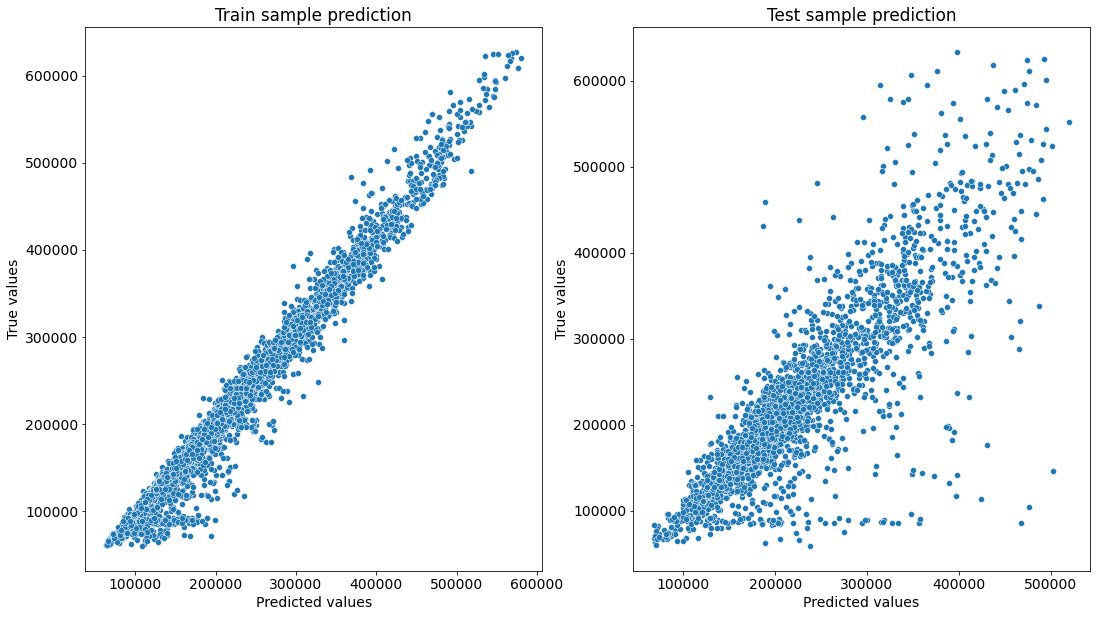

In [57]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [58]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.77096653, 0.71417017, 0.76043812])

In [59]:
cv_score.mean()

0.7485249405476561

#### Важность признаков

In [60]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.203249
22,MedM2PriceByDistrict,0.137111
0,Rooms,0.115919
2,LifeSquare,0.109719
19,DistrictSize,0.062484
11,Social_2,0.044838
10,Social_1,0.040271
6,HouseYear,0.037642
12,Social_3,0.034541
3,KitchenSquare,0.031465


In [61]:
test_df.shape

(5000, 24)

In [62]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [63]:
predictions = rf_model.predict(test_df)
predictions

array([161184.11107213, 131086.13810139, 141415.77260025, ...,
       147685.88213631, 191272.16562275, 243507.36416448])

In [64]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161184.111072
1,5925,131086.138101
2,960,141415.772600
3,3848,130502.524770
4,746,188477.895263


In [65]:
submit.to_csv('my_pred_V2.csv', index=False)